<a href="https://colab.research.google.com/github/mohitmeht/Research_codes/blob/master/Simulating_voltage_response_in_Li_air.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plotting polarization curve using Prof. Petru Andrei's equation as discussed in (Mehta, Bevara, and Andrei, “Maximum Theoretical Power Density of Lithium–Air Batteries with Mixed Electrolyte.”) DOI: [10/gf8cvs](https://doi.org/10/gf8cvs).


---
Hit the play button to run the cell of code. Each cell returns either a checkmark (✅) or an output (text or a plot) to indicate the cell was executed. Since the code runs on the server, the user does not have to install any software on their device.


# Import libraries

In [1]:
import numpy as np
import matplotlib.pylab as plt
from numba import jit,njit,vectorize
from scipy.optimize import fsolve
import pandas as pd
print('\033[1m\u2713\033[0m')

✓


# Simulation constants
The block below includes all the constants and parameters used in computing discharge voltage, power density, specific power, and specific energy.
\begin{align}
F &= 96485 \textrm{ C/mol}\\
T &= 300 \textrm{ K}\\
V_{\textrm{T}} &= {kT}/{q} \textrm{ V}\\
E^{0} &= 2.959 \textrm{ V}\\
\rho_{\textrm{m}}^{\textrm{Li2O2}} &=  2.31 \textrm{ g/cc}\\
M_{\textrm{Li2O2}} &= 45.881 \textrm{ g/mol}\\
n &= 2\\
A &= 1.131 \textrm{ cm}^2\\ 
L_{\textrm{c}} &= 131 \textrm{ }\mu\textrm{m}\\
\epsilon_l &= 0.54\\
\epsilon_s &= 1-\epsilon_l
\end{align}

In [2]:
# ------------ Physical and thermodynamic properties --------------
F_const = 96485 # C/mol
T = 300.; # in K
Eeq = 2.959 # in V
Mprod = 45.881 # in g/mol
rho_Li2O2_mass = 2.31 # in g/cc
# -----------------------------------------------------------------
# ---------------------- Geometrical properties -------------------
n = 2;
A = 1.131; # in cm2
l = 131.0e-4; # in cm, Cathode of 12um
Lsep = 16e-4# in cm
poro_sep = 0.9 
porol = 0.54;
poro_s = 1-porol
brugg = 1.5;
rp0 = 173e-7 # radii of a carbon particle # 20 nm
a = 3*poro_s/rp0 # for sperical particles with li2o2 growing on top
rho_carbon = 2.26 # g/cc
# -----------------------------------------------------------------
## ------------ Electrolyte property ------------------------------
### --- Please uncomment based on the electrolyte being tested ----

#### 1M LiTFSI in DME electrolyte properties ------------
# Do2 = 24e-6; # in cm2/s
# c_int = 8.76e-6;# in mol/cm3

#### 0.1M LiTFSI in TEGDME electrolyte properties (Ref: Huang, Jing, and Amir Faghri. “Analysis of Electrolyte Level Change in a Lithium Air Battery.” Journal of Power Sources 307 (March 2016): 45–55. DOI: 10/f8cx6w)
Do2 = 2.17e-6; # in cm2/s
c_int = 4.84e-6;# in mol/cm3 # O2 concentration at STP
rho_electrolyte = 1.1006 # in g/cc
# -----------------------------------------------------------------
# ------------ Other properties ------------
Deff = np.multiply(Do2,np.power(porol,brugg)); # in cm2/s
# Assumed:  beta = 0.5;
k0 = 0.0020e-8; # in cm/s
ja0 = 6.17e-4; # in A/cm2
rho_Li2O2_R_const = 1e8 # ohm-cm
jdis_lst = np.arange(0.5,10.1,0.1)*1e-3
tdis = np.multiply([0,5,10,30,60],60); # converting minutes to seconds

# -----------------------------------------------------------------
# ----------------- Electrochemical mass properties ---------------
### Using rGO cathode current collector 
rho_rGO = 1.91 # in g/cc 
rho_sep = 2.648 # in g/cc # Celgard Separator
rho_Li = 0.534 # in g/cc
rho_Li2O2 = 2.31 # in g/cc

### Mass for initial dissolved O2 in the electrolyte
molar_Li = 6.941 # in g/mol
molar_mass_O2 = 32 # g/mol
molar_Li2O2 = 45.881 # in g/mol
molar_conc_O2_STP = c_int
# -----------------------------------------------------------------
# -------------------- Dataframe to collect data ------------------
df = pd.DataFrame()
print('\033[1m\u2713\033[0m')

✓


# Define functions 

In [3]:
@njit(parallel=True,fastmath=True)
def thermalvoltage(T=300):
  kb = 1.381e-23 # in Joules/Kelvin
  eV = 1.602e-19 # in Joules
  kb_div_eV = np.divide(kb,eV) 
  ThermalVoltage = np.multiply(T,kb_div_eV)
  return ThermalVoltage

@njit(parallel=True,fastmath=True,target='cpu')
def f(x,n,F,Deff,c_int,Lc,j_dis):
  Fa_const = n*F*A*Deff*c_int
  tanh_func = np.tanh(np.divide(Lc,x))
  Fa = np.multiply(Fa_const,tanh_func)
  Fb = np.multiply(j_dis,x)
  # print("{}\n{}\n{}\n{}\n{}\n{}\n{}".format(n,F,A,Deff,c_int,l,I_dis))
  return np.subtract(Fa,Fb) #F = (n.*F_const.*A.*Deff.*c_int.*tanh(Lc./x))-(j_dis.*x));

@jit(parallel=True,fastmath=True)
def petru_equation(n,F,A,Deff,c_int,l,jdis):
  x0 = np.multiply(0.1,np.ones_like(jdis))
  lam = fsolve(func=f,x0=x0,args=(n,F,Deff,c_int,l,jdis))
  return lam

@njit(parallel=True,fastmath=True)
def kc(Deff,lam):
  return np.divide(Deff,np.power(lam,2.))

@njit(parallel=True,fastmath=True)
def eta_c_sinh(Vt,kc,k0,a):
  return -Vt*np.arcsinh(kc/(2.*k0*a))

@njit(parallel=True,fastmath=True)
def eta_a_sinh(Vt,jdis,ja0):
  return -2.*Vt*np.arcsinh(jdis/ja0/2.)
# def petru_equation(n,F,A,Deff,c_int,l,jdis):  

@njit(parallel=True,fastmath=True)
def eta_sinh(eta_a_sinh,eta_c_sinh):
  return eta_a_sinh + eta_c_sinh

@jit(parallel=True,fastmath=True)
def Vcell(Eeq,eta_electrochem,eta_Li2O2):
  value = np.subtract(np.add(Eeq,eta_electrochem),eta_Li2O2) #Eeq + eta_electrochem - eta_Li2O2
  value[value<0.0] = np.nan
  return value

@njit(parallel=True,fastmath=True)
def epsiLi2O2(jdis_lst,tdis,n,Lc):
  Mprod = 45.881 # in g/mol
  rho_Li2O2_mass = 2.31 # in g/cc
  F_const = 96485
  return (Mprod*jdis_lst*tdis) / (n*F_const*Lc*rho_Li2O2_mass)  

@njit(parallel=True,fastmath=True)
def cathode_rGO_CC_mass(A,Lcc=4e-4): # One of the thin Current Collector technologies being discussed in the literature 
  rho_rGO = 1.91 # in g/cc
  # Lcc = 4e-4 # in cm
  CC_volume = A*Lcc # in cm3
  return rho_rGO*CC_volume # in g

@njit(parallel=True,fastmath=True)
def anode_Li_CC_mass(A,Lan): # One of the thin Current Collector technologies being discussed in the literature 
  rho_LiCNT_UGF = 0.8 # in g/cc
  volume = A*Lan # in cm3
  return rho_LiCNT_UGF*volume # in g

@njit(parallel=True,fastmath=True)
def tLi2O2(tdis,rp0,alpha,jdis_lst,Lc):
  A = rp0
  B_inroot = 1. + (alpha*tdis*jdis_lst/Lc)
  B = np.power(B_inroot,1/3)
  thickness = A*(B- 1.)
  return thickness  

print('\033[1m\u2713\033[0m')  

✓


# Compute thermal voltage

In [4]:
Vt = thermalvoltage(T)
print('\033[1m\u2713\033[0m')

✓


# Compute diffusion length ($\lambda$)
\begin{equation}
\lambda = \tanh^{-1}\left(\frac{a}{b}\right)
\end{equation}
Diffusion length ($\lambda$) is based on Petru's theory to compute the electrochemical impedance spectra in Li-air/O$_2$ batteries. 
This function return a value, lambda.
$\lambda^2 = \frac{D_\textrm{eff}}{k}$ is in cm.

\begin{equation}
\lambda I_F= nFAD_\textrm{eff}c_{o_2}\tanh\left(\frac{l}{\lambda}\right)
\end{equation} 
or 
\begin{equation}
j_F \lambda= nFD_\textrm{eff}c_{o_2}\tanh\left(\frac{l}{\lambda}\right)
\end{equation}
where, 

$n$ is the number of charge transfer electrons, 

$F_\textrm{const}$ is the Faradaic constant in C/mol,

$A$ is the cross sectional area of the cathode  in cm$^2$ (removed when using current density and not current),

$D\textrm{eff}$ is the effective oxygen diffusion coefficient in the organic electrolyte in cm$^2$/s,

$L_c$ = Length of the cathode in cm,

$j_{dis}$ is the value of the dc discharge current density in A/cm$^2$,

$f$ is the function used to solve the non-linear equation using a numerical receipe to find the diffusion length ($\lambda$),

$c_\textrm{int}$ is the inital concentration of oxygen dissolved in the electrolyte in mol/cm$^3$.

The diffusion length is required to compute the voltage drop due to oxygen concentration polarization.

In [5]:
lam  = petru_equation(n,F_const,A,Deff,c_int,l,jdis_lst)
k = kc(Deff,lam)
print('\033[1m\u2713\033[0m')

✓


# Compute discharge voltage (t=0)
The open circuit voltage as a result of oxygen polarization is calculated below. This formulation neglects the change in microstructural properties of the cathode such as porosity, tortuosity, and active surface area, and the voltage drop across lithium peroxide. The results from this relationship is the optimistic estimate of the OCV or the plateau voltage.

In [6]:
eta_c = eta_c_sinh(Vt,k,k0,a)
eta_a = eta_a_sinh(Vt,jdis_lst,ja0)
eta_ac = eta_sinh(eta_a,eta_c)
V = Eeq + eta_ac
print('\033[1m\u2713\033[0m')

✓


## Plot the polarization curve 

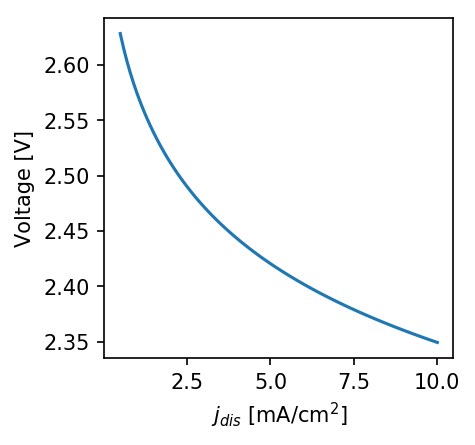

In [7]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.set_xlabel('$j_{dis}$ [mA/cm$^{2}$]')
ax1.set_ylabel('Voltage [V]')  
ax1.plot(jdis_lst*1.0e3,V,'-',color='tab:blue')
plt.show()

## Adding time information
Adding voltage drop from Li2O2 deposition. This assumes that concentration polarization does not change significantly with deposition product changing the porosity, tortuosity, and overpotential. 
The cell voltage at time $\tau$ is 
\begin{equation}
V_{\textrm{cell}}\left(t_{\textrm{dis}}\right) = E_{0} - \eta_{A} - \eta_{c}\left(t_{\textrm{dis}}\right) - \eta_{\textrm{prod}}\left(t_{\textrm{dis}}\right)
\end{equation}
The values of $\eta_A$ and $E_0$ were computed earlier. 

### Change in porosity of Li2O2
The foremost parameter that changes during discharge is change in volume fraction of lithium peroxide ($\epsilon_{\textrm{Li}_2\textrm{O}_2}$), and hence the electrolyte.
\begin{equation}
\epsilon_{\textrm{Li}_2\textrm{O}_2} = \frac{M_{\textrm{Li}_2\textrm{O}_2}j_{\textrm{dis}}t_{\textrm{dis}}}{nFL_{\textrm{c}}\rho_{\textrm{Li}_2\textrm{O}_2}}
\end{equation}

In [8]:
df['epsiLi2O2_0min'] = epsiLi2O2(jdis_lst,tdis[0],n,l)
df['epsiLi2O2_5min'] = epsiLi2O2(jdis_lst,tdis[1],n,l)
df['epsiLi2O2_10min'] = epsiLi2O2(jdis_lst,tdis[2],n,l)
df['epsiLi2O2_30min'] = epsiLi2O2(jdis_lst,tdis[3],n,l)
df['epsiLi2O2_60min'] = epsiLi2O2(jdis_lst,tdis[4],n,l)
print('\033[1m\u2713\033[0m')

✓


#### Plot

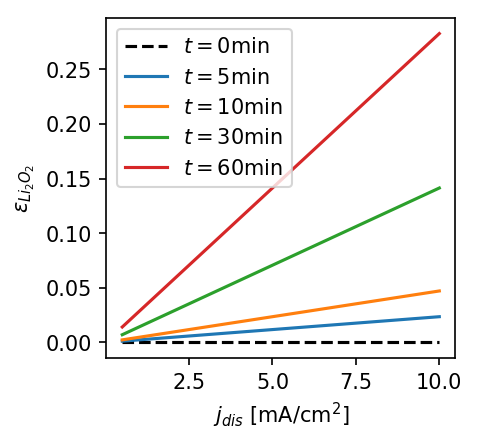

In [9]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,df['epsiLi2O2_0min'].values,'--',color='black')
ax1.plot(jdis_lst*1e3,df['epsiLi2O2_5min'].values)
ax1.plot(jdis_lst*1e3,df['epsiLi2O2_10min'].values)
ax1.plot(jdis_lst*1e3,df['epsiLi2O2_30min'].values)
ax1.plot(jdis_lst*1e3,df['epsiLi2O2_60min'].values)
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$\epsilon_{{Li}_2{O}_2}$');
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);

### Computing cathode overpotential $n_c\left(t_{\textrm{dis}}\right)$ 
The explicit relation is 
\begin{equation}
n_c\left(t_{\textrm{dis}}\right) = j_{\textrm{dis}}\rho_{\textrm{Li}_2\textrm{O}_2}\left(t_{\textrm{dis}}\right) \delta_{\textrm{Li}_2\textrm{O}_2}\left(t_{\textrm{dis}}\right)
\end{equation}
where $\delta_{\textrm{Li}_2\textrm{O}_2}$ is the thickness of the discharge product assuming lthium peroxide grows uniformly on a carbon particle and the growth rate and the lithium peroxide thickness is same throughout the cathode (a naiive assumption), and this does not include the dependency on the change in the concentration gradient.
\begin{equation}
\delta_{\textrm{Li}_2\textrm{O}_2} = r_{p,0}\left[\sqrt[3]{1+\frac{\alpha t_{\textrm{dis}} j_{\textrm{dis}}}{L_c}}-1\right]
\end{equation}
where $\alpha$ is 
\begin{equation}
\alpha = \frac{AM_{\textrm{Li}_2\textrm{O}_2}}{n\epsilon_{s,0}F\rho_{\textrm{Li}_2\textrm{O}_2}^{\textrm{mass}}}
\end{equation}

Initially, assuming, $\rho_{\textrm{Li}_2\textrm{O}_2}\left(t_{\textrm{dis}}\right) = \rho_{\textrm{Li}_2\textrm{O}_2}$

#### Compute model constant $\alpha$

In [10]:
alpha = A*Mprod/n/poro_s/F_const/rho_Li2O2_mass
print('\u03B1 = {:.4e}'.format(alpha))

α = 2.5307e-04


#### Compute thickness, $\delta_{\textrm{prod}}$, at different $t_{\textrm{dis}}$


In [11]:
df['dLi2O2_0min'] = tLi2O2(tdis[0],rp0,alpha,jdis_lst,l)
df['dLi2O2_5min'] = tLi2O2(tdis[1],rp0,alpha,jdis_lst,l)
df['dLi2O2_10min'] = tLi2O2(tdis[2],rp0,alpha,jdis_lst,l)
df['dLi2O2_30min'] = tLi2O2(tdis[3],rp0,alpha,jdis_lst,l)
df['dLi2O2_60min'] = tLi2O2(tdis[4],rp0,alpha,jdis_lst,l)
print('\033[1m\u2713\033[0m')

✓


#### Plot lithium peroxide thickness as a function of $j_{dis}$

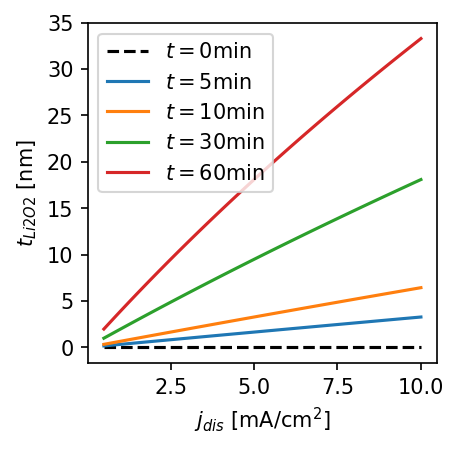

In [12]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,1e7*df['dLi2O2_0min'].values,'--',color='black')
ax1.plot(jdis_lst*1e3,1e7*df['dLi2O2_5min'].values)
ax1.plot(jdis_lst*1e3,1e7*df['dLi2O2_10min'].values)
ax1.plot(jdis_lst*1e3,1e7*df['dLi2O2_30min'].values)
ax1.plot(jdis_lst*1e3,1e7*df['dLi2O2_60min'].values)
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$t_{Li2O2}$ [nm]');
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);

### Compute $\eta_{\textrm{Li}_2 \textrm{O}_2}$ for t = 0, 5, 10, 30, and 60 minutes
I would like to point out, $\rho_{\textrm{Li}_2\textrm{O}_2}$ is assumed to be independent of time or thickness of lithium peroxide, which has been shown to vary with thickness (assuming electron tunneling is the reaction mechanism)


In [13]:
df['eta_Li2O2_0min'] = jdis_lst*rho_Li2O2_R_const*df['dLi2O2_0min'].values
df['eta_Li2O2_5min'] = jdis_lst*rho_Li2O2_R_const*df['dLi2O2_5min'].values
df['eta_Li2O2_10min'] = jdis_lst*rho_Li2O2_R_const*df['dLi2O2_10min'].values
df['eta_Li2O2_30min'] = jdis_lst*rho_Li2O2_R_const*df['dLi2O2_30min'].values
df['eta_Li2O2_60min'] = jdis_lst*rho_Li2O2_R_const*df['dLi2O2_60min'].values
print('\033[1m\u2713\033[0m')

✓


#### Compute cell voltage

In [14]:
df['Vcell_0min'] = Vcell(Eeq,eta_ac,df['eta_Li2O2_0min'].values)
df['Vcell_5min'] = Vcell(Eeq,eta_ac,df['eta_Li2O2_5min'].values)
df['Vcell_10min'] = Vcell(Eeq,eta_ac,df['eta_Li2O2_10min'].values)
df['Vcell_30min'] = Vcell(Eeq,eta_ac,df['eta_Li2O2_30min'].values)
df['Vcell_60min'] = Vcell(Eeq,eta_ac,df['eta_Li2O2_60min'].values)
print('\033[1m\u2713\033[0m')

✓


#### Plot the polarization curve

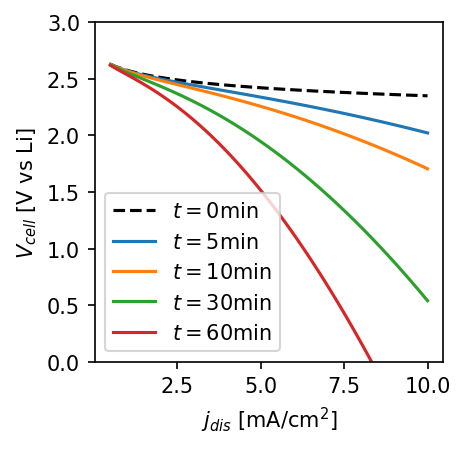

In [15]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,df['Vcell_0min'].values,'--',color='black')
ax1.plot(jdis_lst*1e3,df['Vcell_5min'].values)
ax1.plot(jdis_lst*1e3,df['Vcell_10min'].values)
ax1.plot(jdis_lst*1e3,df['Vcell_30min'].values)
ax1.plot(jdis_lst*1e3,df['Vcell_60min'].values)
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$V_{{cell}}$ [V vs Li]');
ax1.set_ylim([0,3])
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);

# Calculate mass

## Mass of each cell component

### Cathode mass with current collector

#### cathode mass (carbon only)

In [16]:
cathode_volume = A*l
cathode_electrolyte_volume = cathode_volume*porol # in cm3
cathode_mass_density = (rho_electrolyte*porol) + (rho_carbon*poro_s)
cathode_mass = (cathode_mass_density*cathode_volume)
print('The cathode mass (electrochemical) is \033[1m{:.3f}mg\033[0m.'.format(cathode_mass*1e3))

The cathode mass (electrochemical) is 24.208mg.


#### rGO cathode current collector 

In [17]:
cat_CC_mass = cathode_rGO_CC_mass(A)
print('The mass of rGO current collector is \033[1m{:.3f}mg\033[0m.'.format(cat_CC_mass*1e3))

The mass of rGO current collector is 0.864mg.


#### Total cathode mass

In [18]:
cathode_mass_w_CC = cathode_mass + cat_CC_mass
print('The cathode mass with rGO current collector is \033[1m{:.3f}mg\033[0m.'.format(cathode_mass_w_CC*1e3))

The cathode mass with rGO current collector is 25.072mg.


### Lithium anode mass with CNT-UGF current collector (assuming the whole cathode is filled with Li$_2$O$_2$)

In [19]:
Lan = rho_Li2O2*cathode_volume/molar_Li2O2*molar_Li/rho_Li/A
anode_mass_w_CC = anode_Li_CC_mass(A,Lan)
print('The minimum anode thickness should be \033[1m{:.3f}\u03BCm\033[0m.The anode mass with Li/CNT-Ultrathin Graphite Foam current collector is \033[1m{:.3f}mg\033[0m.'.format(Lan*1e4,anode_mass_w_CC*1e3))

The minimum anode thickness should be 85.730μm.The anode mass with Li/CNT-Ultrathin Graphite Foam current collector is 7.757mg.


### Separator mass

In [20]:
separator_volume = A*Lsep # in cm3
separator_electrolyte_volume = separator_volume*poro_sep # in cm3
separator_solid_volume = separator_volume*(1-poro_sep) # in cm3
separator_mass = (separator_electrolyte_volume*rho_electrolyte) + (separator_solid_volume*rho_sep)
print('The separator mass is \033[1m{:.3f}mg\033[0m.'.format(separator_mass*1e3))

The separator mass is 2.272mg.


### Dissolved oxygen mass

In [21]:
electrolyte_volume = separator_electrolyte_volume + cathode_electrolyte_volume # in cm3
mass_dissolved_O2 = molar_conc_O2_STP*molar_mass_O2*electrolyte_volume # in g
print('The mass of oxygen in the electrolyte is \033[1m{:.3f}\u03bcg\033[0m'.format(mass_dissolved_O2*1e6));

The mass of oxygen in the electrolyte is 1.491μg


## Total mass

In [22]:
tot_cell_mass = anode_mass_w_CC + separator_mass + cathode_mass_w_CC + mass_dissolved_O2
print('The total cell mass is \033[1m{:.3f}mg\033[0m.'.format(tot_cell_mass*1e3))

The total cell mass is 35.102mg.


# Plotting performance plots

## Compute Cell Power


---


The power is computed for four discharge times: $0$ mins, $5$ mins, $10$ mins, $30$ mins, $60$ mins. 

---


\begin{equation}
P\left(t\right) = A_{\textrm{cross}}j_{\textrm{dis}}V_{\textrm{dis}}\left(t\right)
\end{equation}

In [23]:
df['Pcell_0min'] = jdis_lst*A*df['Vcell_0min']
df['Pcell_5min'] = jdis_lst*A*df['Vcell_5min']
df['Pcell_10min'] = jdis_lst*A*df['Vcell_10min']
df['Pcell_30min'] = jdis_lst*A*df['Vcell_30min']
df['Pcell_60min'] = jdis_lst*A*df['Vcell_60min']
print('\033[1m\u2713\033[0m')

✓


### Plot Power vs Current Density (mA/cm$^2$)

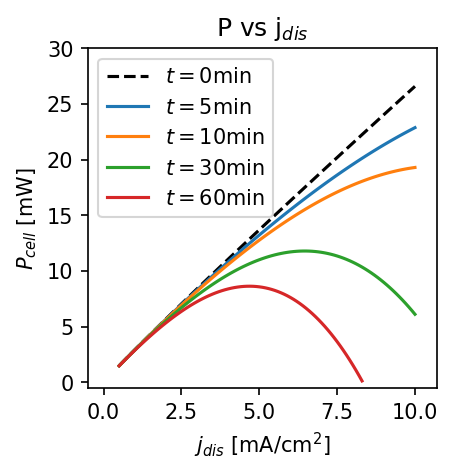

In [24]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,df['Pcell_0min']*1e3,'--',color='black')
ax1.plot(jdis_lst*1e3,df['Pcell_5min']*1e3)
ax1.plot(jdis_lst*1e3,df['Pcell_10min']*1e3)
ax1.plot(jdis_lst*1e3,df['Pcell_30min']*1e3)
ax1.plot(jdis_lst*1e3,df['Pcell_60min']*1e3)
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$P_{{cell}}$ [mW]');
ax1.set_ylim([-0.5,30])
ax1.set_xlim([-0.5,10.7])
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);
ax1.set_title('P vs j$_{dis}$');

## Compute Specific Power


---


The values of specific power are in W/Kg, and they are computed for four discharge times: $0$ mins, $5$ mins, $10$ mins, $30$ mins, $60$ mins. 

---


\begin{equation}
SP = \frac{P\left(t\right)}{m_{\textrm{a}} + m_{\textrm{a,cc}} + m_{\textrm{sep}} + m_{\textrm{c}} + m_{\textrm{c,cc}} + m_{\textrm{elec}} + m_{\textrm{O}_2}}
\end{equation}

In [25]:
# converting units of power from W to mW by multiplying 1e3
df['SPcell_0min']  = df['Pcell_0min'].values*1e3/tot_cell_mass
df['SPcell_5min']  = df['Pcell_5min'].values*1e3/tot_cell_mass
df['SPcell_10min'] = df['Pcell_10min'].values*1e3/tot_cell_mass
df['SPcell_30min'] = df['Pcell_30min'].values*1e3/tot_cell_mass
df['SPcell_60min'] = df['Pcell_60min'].values*1e3/tot_cell_mass
print('\033[1m\u2713\033[0m')

✓


### Plot Specific Power (W/Kg) vs Current Density (mA/cm$^2$)

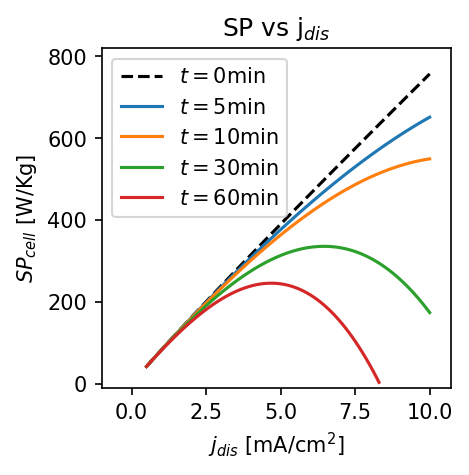

In [26]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,df['SPcell_0min'],'--',color='black')
ax1.plot(jdis_lst*1e3,df['SPcell_5min'])
ax1.plot(jdis_lst*1e3,df['SPcell_10min'])
ax1.plot(jdis_lst*1e3,df['SPcell_30min'])
ax1.plot(jdis_lst*1e3,df['SPcell_60min'])
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$SP_{{cell}}$ [W/Kg]');
ax1.set_ylim([-10,820])
ax1.set_xlim([-1,10.7])
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);
ax1.set_title('SP vs j$_{dis}$');

## Compute Specific Energy


---


The values of specific energy are in Wh/Kg, and are computed for four discharge times: $0$ mins, $5$ mins, $10$ mins, $30$ mins, $60$ mins. 

---


\begin{equation}
SE = SP\times t_{\textrm{dis}}
\end{equation}

In [27]:
# converting units of power from W to mW by multiplying 1e3
df['SEcell_0min']  = df['SPcell_0min']*1e-3/60 # assuming 0 = 1e-3min
df['SEcell_5min']  = df['SPcell_5min']*5/60
df['SEcell_10min']  = df['SPcell_10min']*10/60
df['SEcell_30min']  = df['SPcell_30min']*30/60
df['SEcell_60min']  = df['SPcell_60min']*60/60
print('\033[1m\u2713\033[0m')

✓


### Plot Specific Energy (Wh/Kg) vs Current Density (mA/cm$^2$)

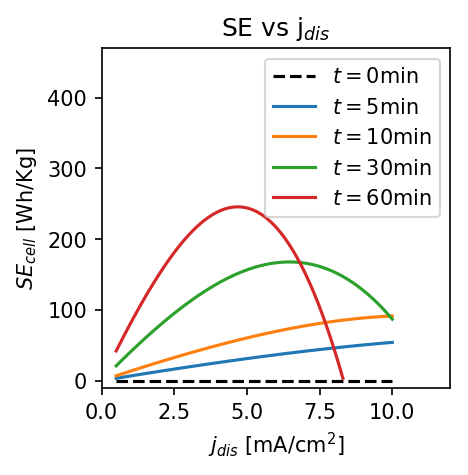

In [28]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(jdis_lst*1e3,df['SEcell_0min'],'--',color='black')
ax1.plot(jdis_lst*1e3,df['SEcell_5min'])
ax1.plot(jdis_lst*1e3,df['SEcell_10min'])
ax1.plot(jdis_lst*1e3,df['SEcell_30min'])
ax1.plot(jdis_lst*1e3,df['SEcell_60min'])
ax1.set_xlabel('$j_{dis}$ [mA/cm$^2$]');
ax1.set_ylabel('$SE_{{cell}}$ [Wh/Kg]');
ax1.set_ylim([-10,470])
ax1.set_xlim([0,12])
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);
ax1.set_title('SE vs j$_{dis}$');

### Plot Specific Power (W/Kg) vs Specific Energy (Wh/Kg)

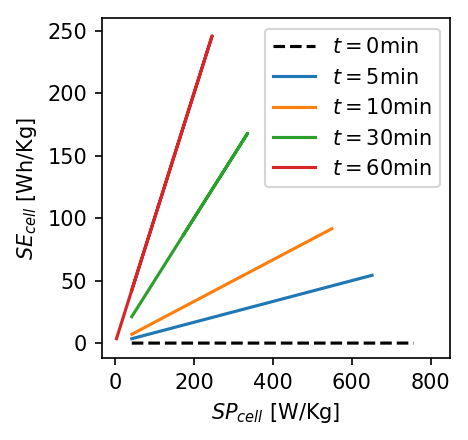

In [63]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax1 = fig1.add_subplot(111)
ax1.set_facecolor('None')
ax1.plot(df['SPcell_0min'],df['SEcell_0min'],'--',color='black')
ax1.plot(df['SPcell_5min'],df['SEcell_5min'])
ax1.plot(df['SPcell_10min'],df['SEcell_10min'])
ax1.plot(df['SPcell_30min'],df['SEcell_30min'])
ax1.plot(df['SPcell_60min'],df['SEcell_60min'])
ax1.set_xlabel('$SP_{{cell}}$ [W/Kg]');
ax1.set_ylabel('$SE_{{cell}}$ [Wh/Kg]');
ax1.set_ylim([-12,260])
ax1.set_xlim([-34,850])
ax1.legend(['$t=0$min','$t=5$min','$t=10$min','$t=30$min','$t=60$min']);
# ax1.set_title('SE vs j$_{dis}$');
# print(ax1.get_ylim())

# plt.plot()
# plt.plot(df['SPcell_5min'],df['SEcell_5min'])
# plt.plot(df['SPcell_10min'],df['SEcell_10min'])
# plt.plot(df['SPcell_30min'],df['SEcell_30min'])
# plt.plot(df['SPcell_60min'],df['SEcell_60min'])


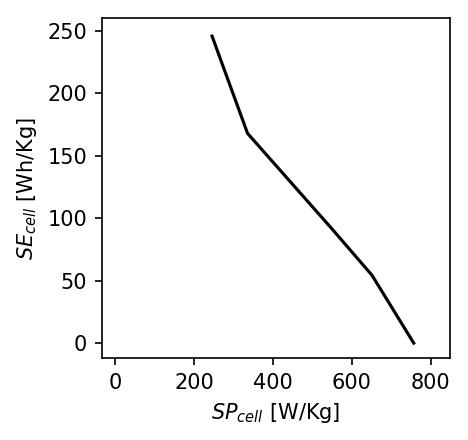

In [65]:
fig1 = plt.figure(num=1,figsize=[3,3],facecolor=None,edgecolor=None,dpi=150)
ax2 = fig1.add_subplot(111)
ax2.set_facecolor('None')
xplotval = [max(df['SPcell_0min']),max(df['SPcell_5min']),max(df['SPcell_10min']),max(df['SPcell_30min']),max(df['SPcell_60min'])]
yplotval = [max(df['SEcell_0min']),max(df['SEcell_5min']),max(df['SEcell_10min']),max(df['SEcell_30min']),max(df['SEcell_60min'])] 
ax2.plot(xplotval,yplotval,'-',color='black')
ax2.set_xlabel('$SP_{{cell}}$ [W/Kg]');
ax2.set_ylabel('$SE_{{cell}}$ [Wh/Kg]');
ax2.set_ylim([-12,260]);
ax2.set_xlim([-34,850]);

# Taking a peek at the raw computed data

In [30]:
df.head()

,epsiLi2O2_0min,epsiLi2O2_5min,epsiLi2O2_10min,epsiLi2O2_30min,epsiLi2O2_60min,dLi2O2_0min,dLi2O2_5min,dLi2O2_10min,dLi2O2_30min,dLi2O2_60min,eta_Li2O2_0min,eta_Li2O2_5min,eta_Li2O2_10min,eta_Li2O2_30min,eta_Li2O2_60min,Vcell_0min,Vcell_5min,Vcell_10min,Vcell_30min,Vcell_60min,Pcell_0min,Pcell_5min,Pcell_10min,Pcell_30min,Pcell_60min,SPcell_0min,SPcell_5min,SPcell_10min,SPcell_30min,SPcell_60min,SEcell_0min,SEcell_5min,SEcell_10min,SEcell_30min,SEcell_60min
0,0.0,0.001179,0.002357,0.007071,0.014143,0.0,1.669405e-08,3.335597e-08,9.968547e-08,1.982416e-07,0.0,0.000835,0.001668,0.004984,0.009912,2.628187,2.627352,2.626519,2.623203,2.618275,0.001486,0.001486,0.001485,0.001483,0.001481,42.340066,42.326618,42.313197,42.259769,42.180382,0.000706,3.527218,7.052200,21.129884,42.180382
1,0.0,0.001414,0.002829,0.008486,0.016971,0.0,2.002900e-08,4.001178e-08,1.194860e-07,2.373550e-07,0.0,0.001202,0.002401,0.007169,0.014241,2.614929,2.613727,2.612528,2.607760,2.600687,0.001774,0.001774,0.001773,0.001770,0.001765,50.551773,50.528541,50.505362,50.413179,50.276460,0.000843,4.210712,8.417560,25.206589,50.276460
2,0.0,0.001650,0.003300,0.009900,0.019800,0.0,2.336266e-08,4.666248e-08,1.392417e-07,2.762946e-07,0.0,0.001635,0.003266,0.009747,0.019341,2.603247,2.601612,2.599981,2.593501,2.583907,0.002061,0.002060,0.002058,0.002053,0.002046,58.713608,58.676724,58.639939,58.493777,58.277400,0.000979,4.889727,9.773323,29.246888,58.277400
3,0.0,0.001886,0.003771,0.011314,0.022628,0.0,2.669505e-08,5.330809e-08,1.589526e-07,3.150625e-07,0.0,0.002136,0.004265,0.012716,0.025205,2.592759,2.590624,2.588494,2.580043,2.567554,0.002346,0.002344,0.002342,0.002334,0.002323,66.830921,66.775873,66.720995,66.503148,66.181237,0.001114,5.564656,11.120166,33.251574,66.181237
4,0.0,0.002121,0.004243,0.012728,0.025457,0.0,3.002615e-08,5.994861e-08,1.786192e-07,3.536604e-07,0.0,0.002702,0.005395,0.016076,0.031829,2.583215,2.580513,2.577820,2.567140,2.551386,0.002629,0.002627,0.002624,0.002613,0.002597,74.908032,74.829669,74.751577,74.441869,73.985043,0.001248,6.235806,12.458596,37.220934,73.985043
